In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [88]:
N_YEARS = 25
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1997-03-28', datetime.date(2022, 3, 28))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


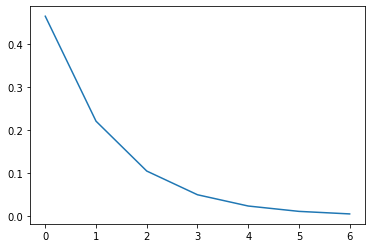

In [89]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [90]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.2213282028967274

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [(first, second) for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
        for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-03-21  18.817072  7.697371  18.817072  7.697371  18.817072  7.697371   
2022-03-22  19.497604  7.860227  19.497604  7.860227  19.497604  7.860227   
2022-03-23  19.181732  7.678011  19.181732  7.678011  19.181732  7.678011   
2022-03-24  19.460978  7.884292  19.460978  7.884292  19.460978  7.884292   
2022-03-25  19.027283  7.736495  19.027283  7.736495  19.027283  7.736495   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-03-21  18.817072  7.697371  18.817072  7.697371  
2022-03-22  19.497604  7.860227  19.497604  7.860227  
2022-03-23  19.181732  7.678011  19.181732  7.678011  
2022-03-24  19.460978  7.884292  19.460978  7.884292  
2022-03-25  19.027283  7.736495  19.027283  7.736495

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                              Close               \
        ^GSPC        ^IXIC         ^NYA       ^W5000       ^GSPC        ^IXIC   
0  790.500000  1269.079956  4392.009766  7517.390137  790.500000  1269.079956   
1  773.880005  1249.510010  4308.060059  7376.839844  773.880005  1249.510010   
2  757.119995  1221.699951  4214.160156  7213.529785  757.119995  1221.699951   
3  759.640015  1216.930054  4227.379883  7222.419922  759.640015  1216.930054   
4  750.109985  1201.000000  4180.540039  7140.669922  750.109985  1201.000000   

                                   High               ... DayToDayChange  \
          ^NYA       ^W5000       ^GSPC        ^IXIC  ...         ^W5000   
0  4392.009766  7517.390137  794.890015  1269.079956  ...            NaN   
1  4308.060059  7376.839844  792.580017  1277.359985  ...       0.981303   
2  4214.160156  7213.529785  773.880005  1246.349976  ...       0.977862   
3  4227.379883  7222.419922  761.489990  1222.260010  ...       1.001232   
4  4180.540039  7140.669922  759.650024  1217.439941  ...       0.988681   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1        0.981303      NaN            NaN            NaN             NaN   
2        0.977862      NaN            NaN            NaN             NaN   
3        1.001232      NaN            NaN            NaN             NaN   
4        0.988681      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

6288   2022-03-21
6289   2022-03-22
6290   2022-03-23
6291   2022-03-24
6292   2022-03-25
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                              Close  \
                 ^GSPC        ^IXIC         ^NYA       ^W5000       ^GSPC   
Date                                                                        
1997-03-26  790.500000  1269.079956  4392.009766  7517.390137  790.500000   
1997-03-27  773.880005  1249.510010  4308.060059  7376.839844  773.880005   
1997-03-31  757.119995  1221.699951  4214.160156  7213.529785  757.119995   
1997-04-01  759.640015  1216.930054  4227.379883  7222.419922  759.640015   
1997-04-02  750.109985  1201.000000  4180.540039  7140.669922  750.109985   

                                                         High               \
                  ^IXIC         ^NYA       ^W5000       ^GSPC        ^IXIC   
Date                                                                         
1997-03-26  1269.079956  4392.009766  7517.390137  794.890015  1269.079956   
1997-03-27  1249.510010  4308.060059  7376.839844  792.580017  1277.359985   
1997-03-31  1221.699951  4214.160156  7213.529785  773.880005  1246.349976   
1997-04-01  1216.930054  4227.379883  7222.419922  761.489990  1222.260010   
1997-04-02  1201.000000  4180.540039  7140.669922  759.650024  1217.439941   

            ... DayToDayChange OvernightChange LogValue IntradayChange  \
            ...         ^W5000          ^W5000    mine1          mine1   
Date        ...                                                          
1997-03-26  ...            NaN             NaN      NaN            NaN   
1997-03-27  ...       0.981303        0.981303      NaN            NaN   
1997-03-31  ...       0.977862        0.977862      NaN            NaN   
1997-04-01  ...       1.001232        1.001232      NaN            NaN   
1997-04-02  ...       0.988681        0.988681      NaN            NaN   

           DayToDayChange OvernightChange LogValue IntradayChange  \
                    mine1           mine1    mine2          mine2   
Date                                                                
1997-03-26            NaN             NaN      NaN            NaN   
1997-03-27            NaN             NaN      NaN            NaN   
1997-03-31            NaN             NaN      NaN            NaN   
1997-04-01            NaN             NaN      NaN            NaN   
1997-04-02            NaN             NaN      NaN            NaN   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
1997-03-26            NaN             NaN  
1997-03-27            NaN             NaN  
1997-03-31            NaN             NaN  
1997-04-01            NaN             NaN  
1997-04-02            NaN             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [32]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282028967274



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.959473239782161
Refitting current best...
Current best ma returns: 4.234926905777702
Fraction Invested: 0.9607454308175882
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.234957500361756
Invested: 0.9607454308175882
New best: 4.234957548202797
Invested: 0.9607454308175882
Round: 200


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.959473239782161
Refitting current best...
Current best ew_ma returns: 4.192761771970988
Fraction Invested: 0.9771609152690672
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning rel_minmax method...
---------------------

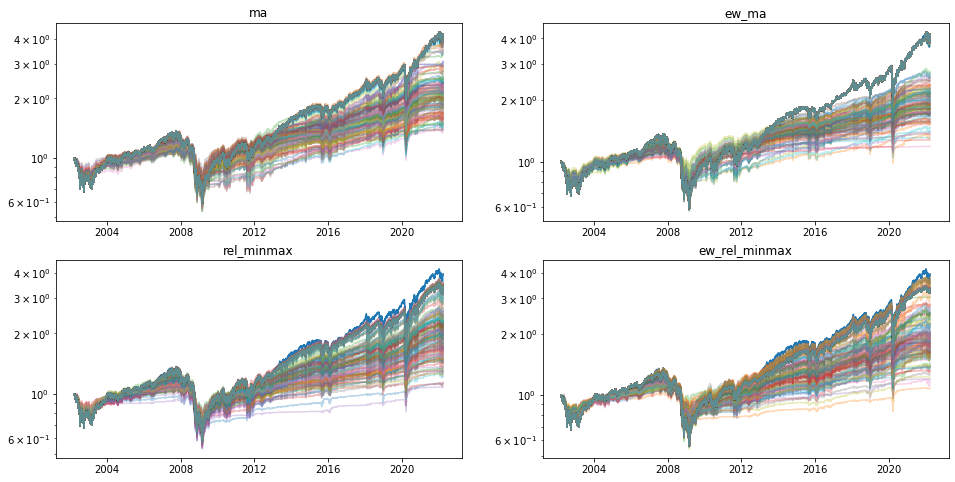

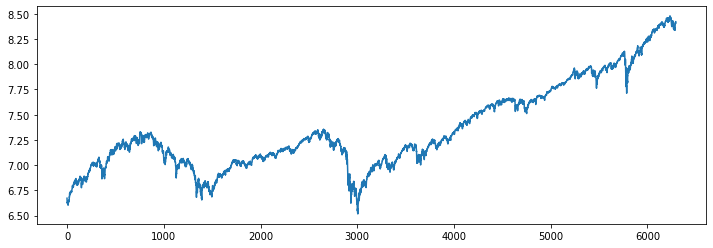

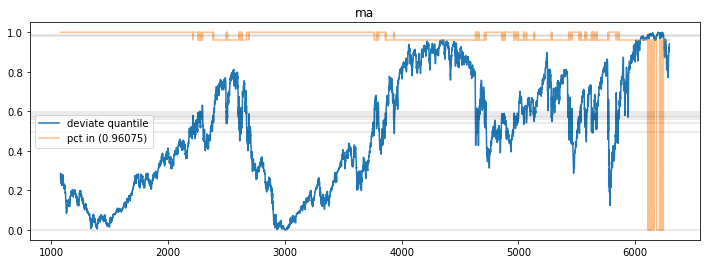

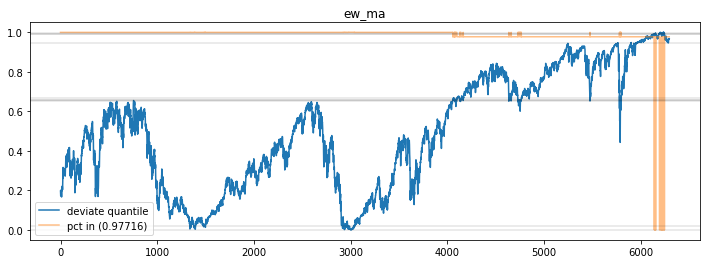

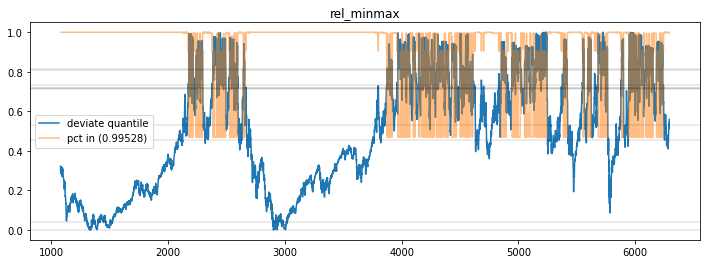

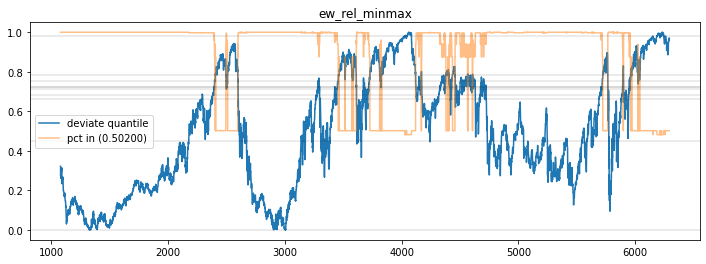

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.6783807907161075
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.6783807907161075
Refitting current best...
Current best ew_ma returns: 9.87283184136893
Fraction Invested: 0.9982053026506663
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 7.6783807907161075
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted 

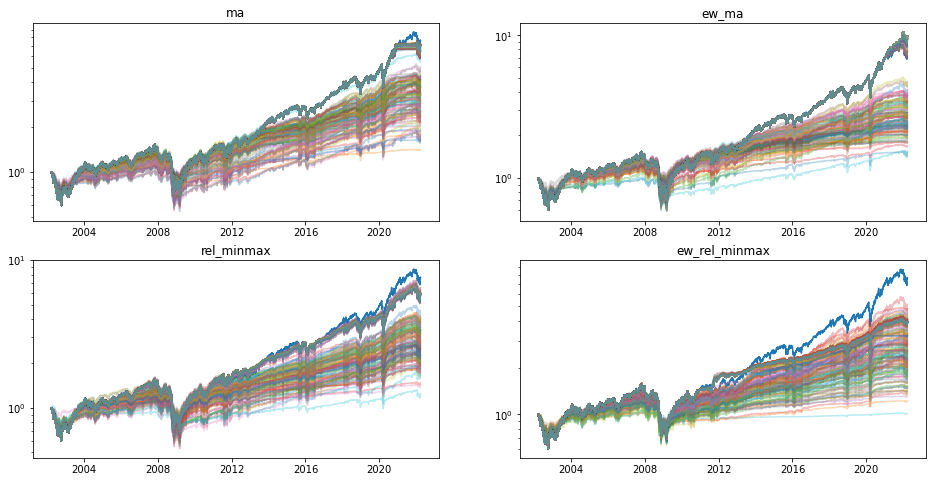

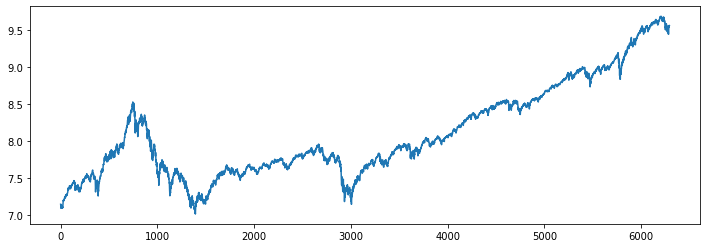

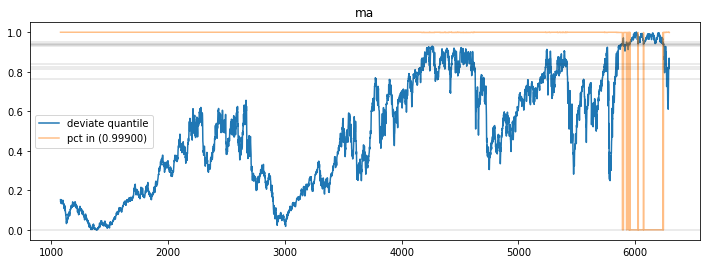

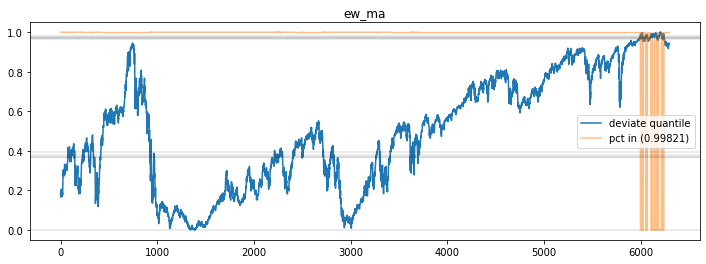

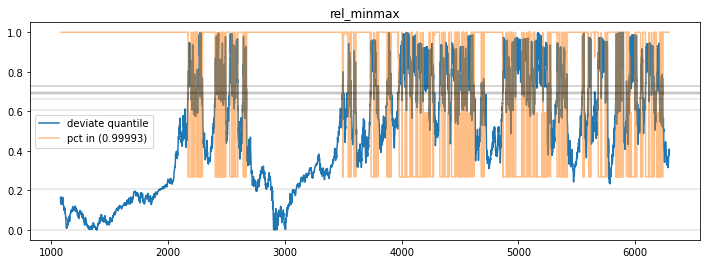

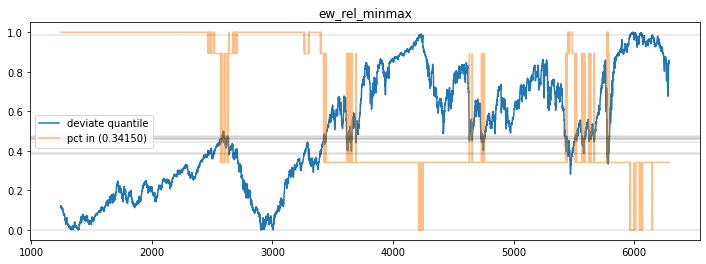

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.638414584718022
Refitting current best...
Current best ma returns: 3.3663633997874083
Fraction Invested: 0.9999999999999282
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.638414584718022
Refitting current best...
Current best ew_ma returns: 3.3755602903227415
Fraction Invested: 4.4517458396942414e-07
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.3755653531399337
Invested: 4.4517458396942414e-07
New best: 3.3755822954668364
Invested: 4.4517458396942414e-07
Round: 200


Beginning rel_minmax method...
------

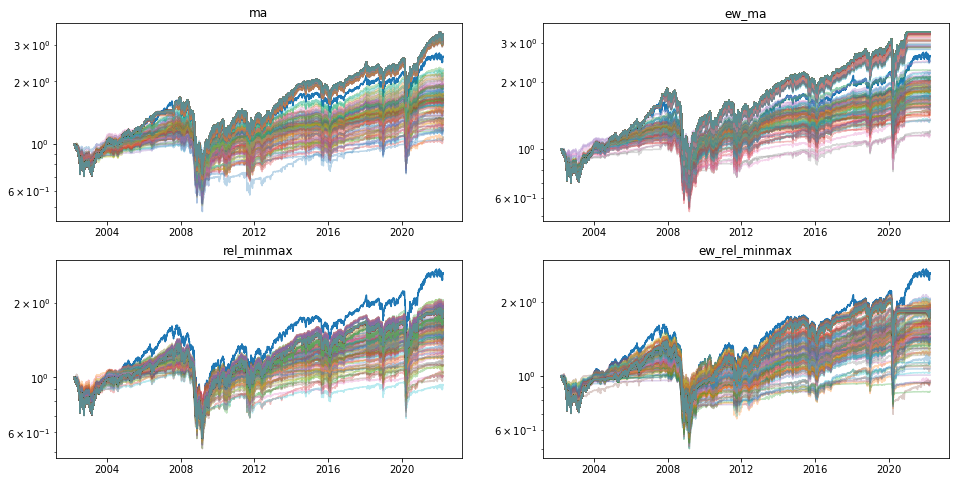

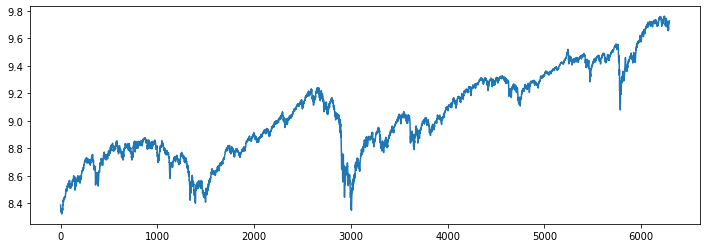

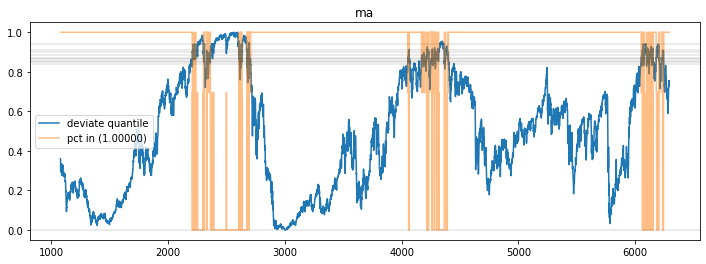

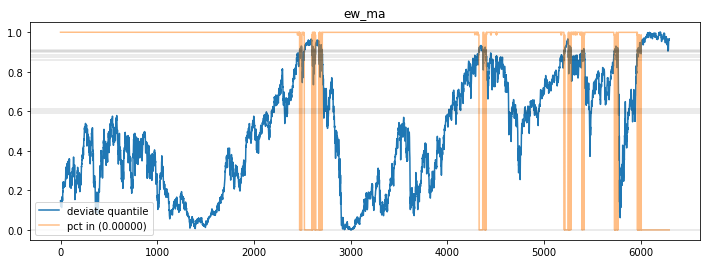

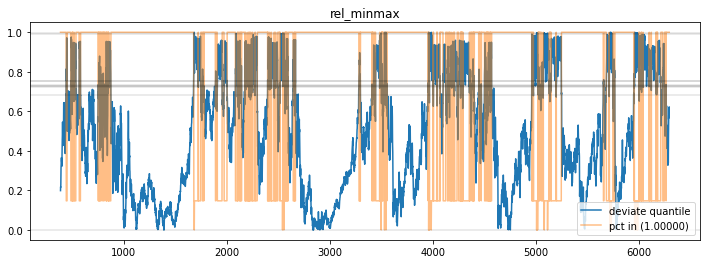

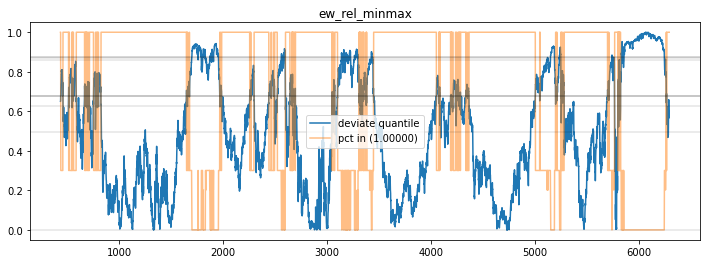

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.226486035707741
Refitting current best...
Current best ma returns: 4.636755350918812
Fraction Invested: 0.9942107987262049
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.226486035707741
Refitting current best...
Current best ew_ma returns: 4.773054044799876
Fraction Invested: 0.9957704631447595
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.773054059467049
Invested: 0.9957704631447595
Round: 200


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.22648

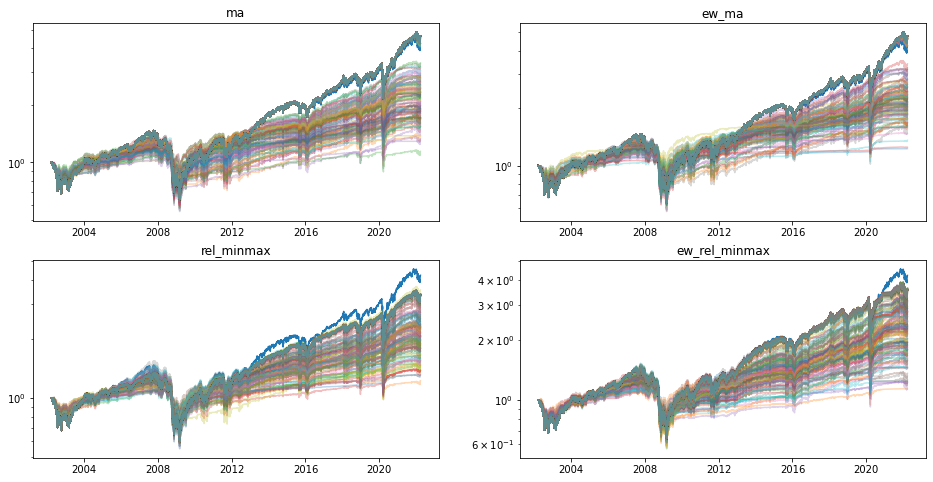

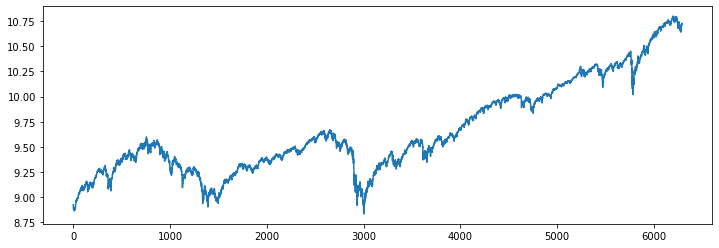

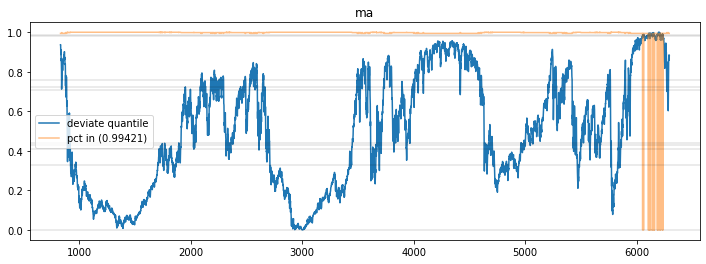

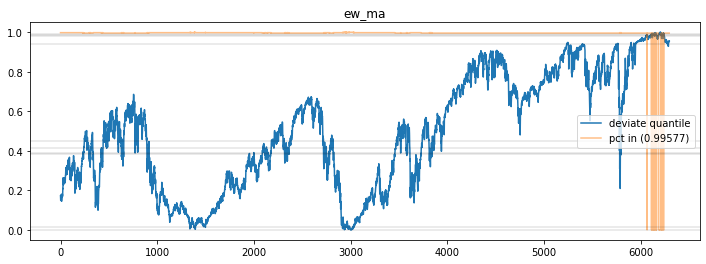

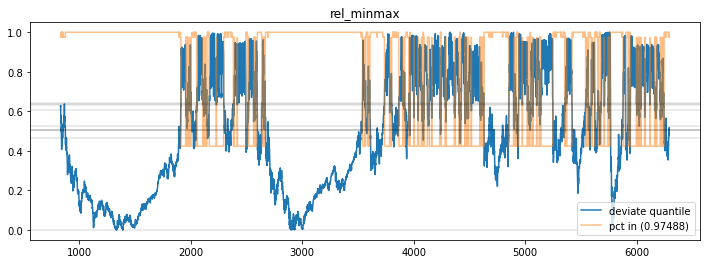

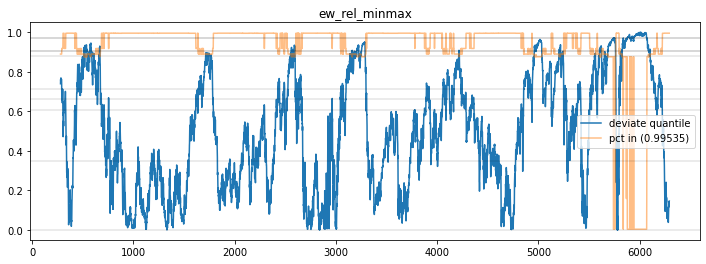

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.413479740690027
Refitting current best...
Current best ma returns: 14.787686575136041
Fraction Invested: 0.9999999998830571
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.413479740690027
Refitting current best...
Current best ew_ma returns: 15.692557187706566
Fraction Invested: 0.9975212090481279
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 13.413479740690027
Refitting current best...
Fraction Inves

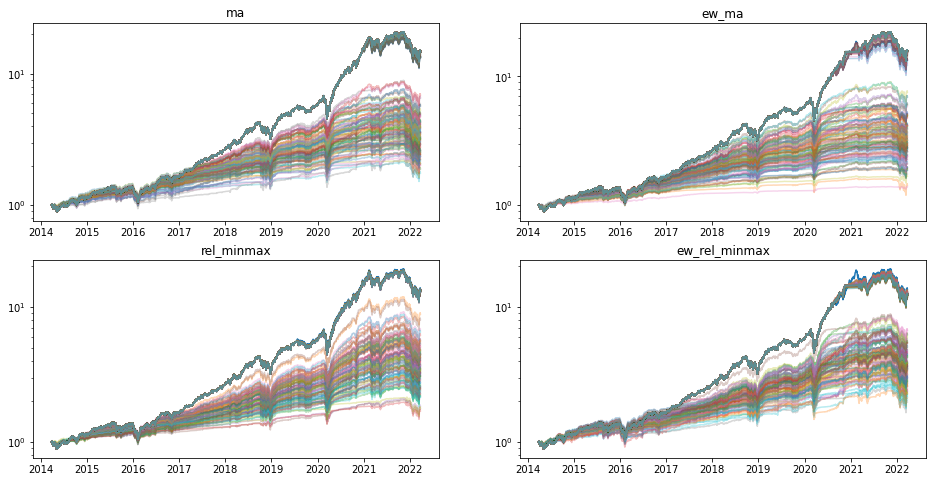

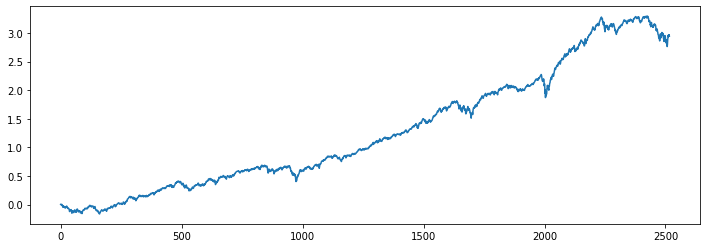

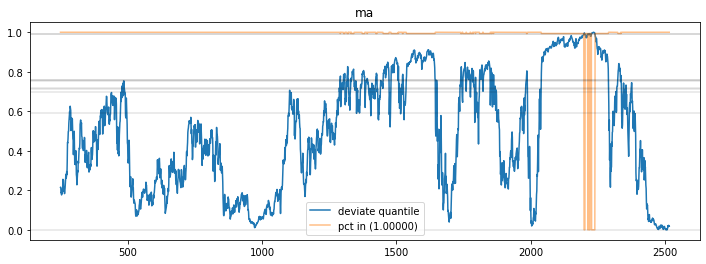

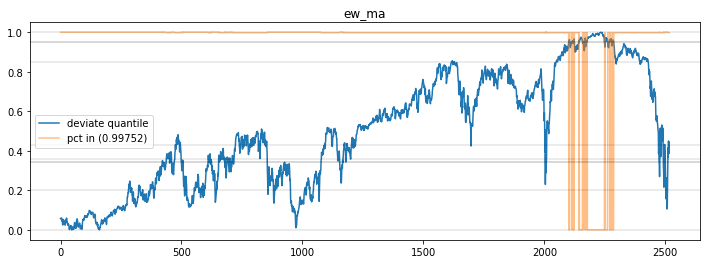

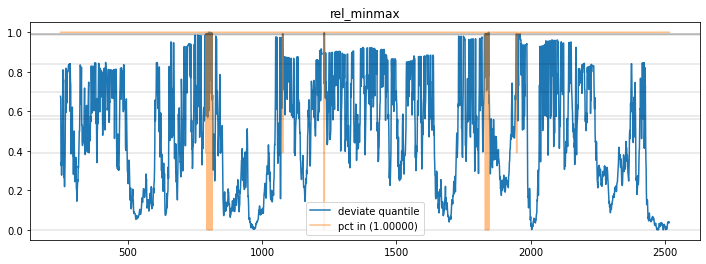

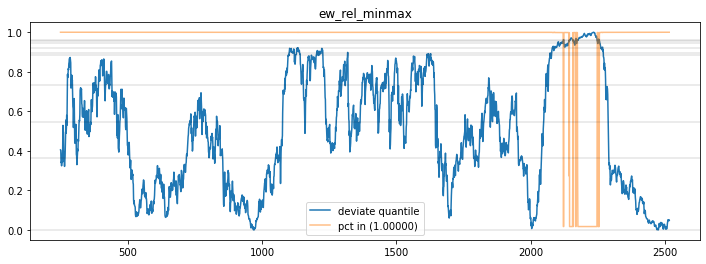

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.4393026833674725
Refitting current best...
Current best ma returns: 7.325775901391533
Fraction Invested: 1.0
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 200


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.4393026833674725
Refitting current best...
Current best ew_ma returns: 8.193110714693617
Fraction Invested: 1.0
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 8.193228051319808
Invested: 1.0
Round: 200


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 5.4393026833674725
Refitting current best...
Fract

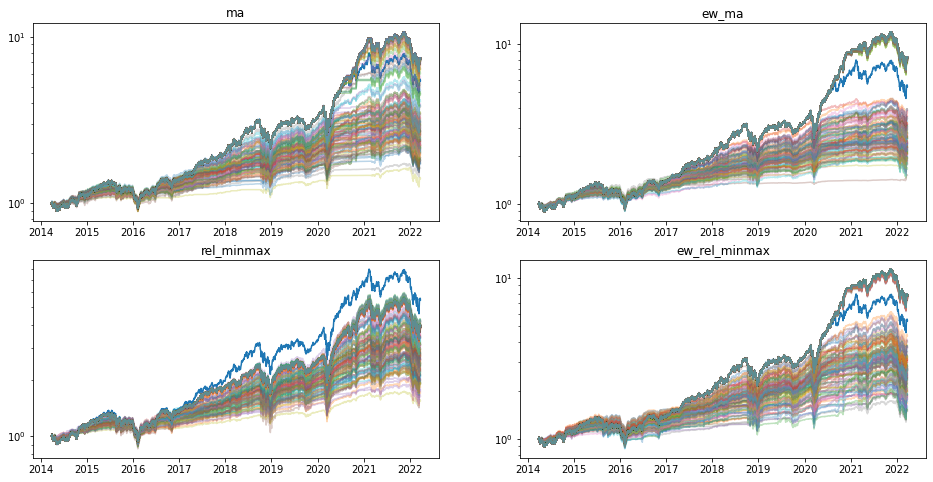

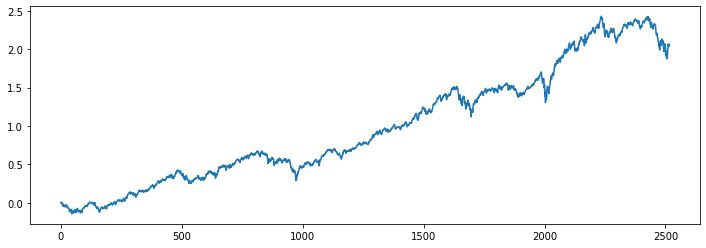

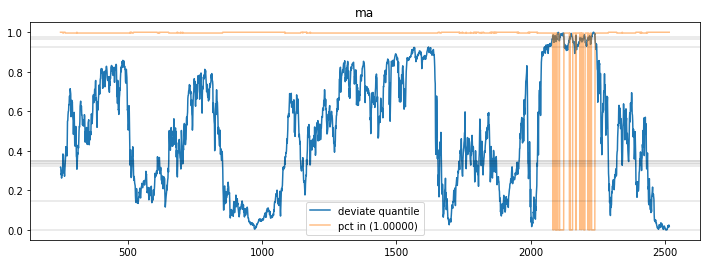

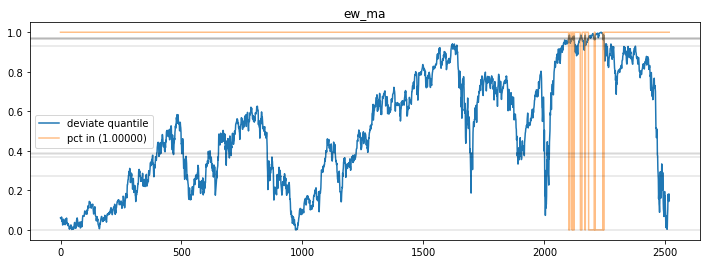

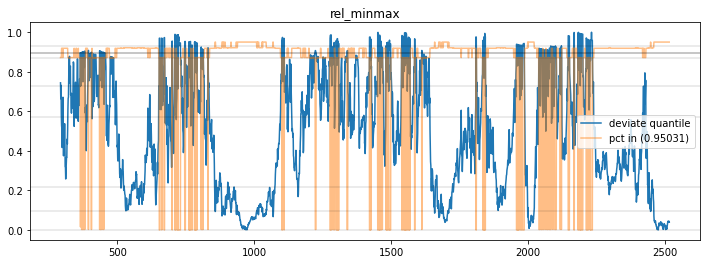

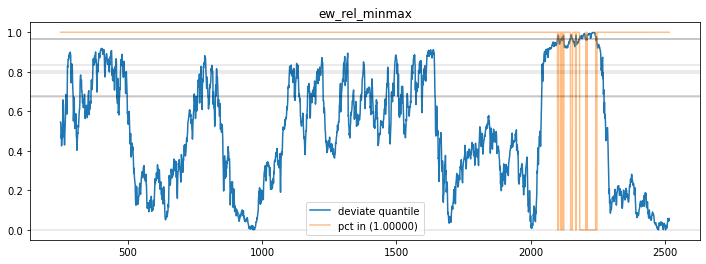

Saving mine2 params...


In [91]:
N_RAND = 100
N_ADJ = 200

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [92]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = best_return
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [93]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 4.234957548202797 (ma)
  0.96074543 in
time param: 1079
qs:
(0.0000 - 0.4974): 1.0000
(0.4974 - 0.5401): 1.0000
(0.5401 - 0.5623): 1.0000
(0.5623 - 0.5687): 1.0000
(0.5687 - 0.5766): 0.9608
(0.5766 - 0.5860): 0.9607
(0.5860 - 0.5980): 0.9607
(0.5980 - 0.9826): 0.9607
(0.9826 - 0.9858): 0.0002
(0.9858 - 1.0000): 0.0000

^IXIC:
  Best Return: 9.87283184136893 (ew_ma)
  0.99820530 in
time param: 1079
qs:
(0.0000 - 0.3686): 1.0000
(0.3686 - 0.3704): 1.0000
(0.3704 - 0.3785): 1.0000
(0.3785 - 0.3917): 0.9982
(0.3917 - 0.9649): 0.9982
(0.9649 - 0.9703): 0.9982
(0.9703 - 0.9714): 0.9602
(0.9714 - 0.9777): 0.9602
(0.9777 - 0.9797): 0.0004
(0.9797 - 1.0000): 0.0000

^NYA:
  Best Return: 3.3755822954668364 (ew_ma)
  0.00000045 in
time param: 1079
qs:
(0.0000 - 0.5898): 1.0000
(0.5898 - 0.6027): 1.0000
(0.6027 - 0.6122): 0.9995
(0.6122 - 0.8612): 0.9995
(0.8612 - 0.8747): 0.9995
(0.8747 - 0.8861): 0.9870
(0.8861 - 0.9013): 0.9870
(0.9013 - 0.9034): 0.9860
(0.9034 - 0.9123):

{'^GSPC': 4.234957548202797,
 '^IXIC': 9.87283184136893,
 '^NYA': 3.3755822954668364,
 '^W5000': 4.773054059467049,
 'mine1': 15.692557187706566,
 'mine2': 8.193228051319808}

In [94]:
multipliers = {}
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]
    den = do_nothing_returns[stock]
    print(f'{stock}: {num} / {den}')
    multipliers[stock] = num / den
    
multipliers

^GSPC: 4.234957548202797 / 3.959473239782161
^IXIC: 9.87283184136893 / 7.6783807907161075
^NYA: 3.3755822954668364 / 2.638414584718022
^W5000: 4.773054059467049 / 4.226486035707741
mine1: 15.692557187706566 / 13.413479740690027
mine2: 8.193228051319808 / 5.4393026833674725


{'^GSPC': 1.0695759995680112,
 '^IXIC': 1.2857960695705692,
 '^NYA': 1.27939798203761,
 '^W5000': 1.129319727816818,
 'mine1': 1.1699094859108718,
 'mine2': 1.5063011801813133}

In [95]:
mults = np.array([multipliers[key] for key in batch + ['mine1', 'mine2']])
mults[-2:] /= 2  # b/c doubling up, and half the timespan
weights = mults / mults.sum()
weights

array([0.17527725, 0.21071042, 0.20966193, 0.18506778, 0.09585972,
       0.1234229 ])

In [96]:
!say qp is dunzo